# Predicted Customer Lifetime Value (pCLV) estimation

There are a couple approaches to calculating Customer Lifetime Value for any businesses. From what I have personally and experienced from working with FP&A analysts, I could tell there are, at least, the following 2 approaches which requires nothing but SQL to find the values. Both are considered historical lookups.

1. Aggregate Model  —  calculating the CLV by using the average revenue per customer based on past transactions. This method gives us a single value for the CLV.
2. Cohort Model  —  grouping the customers into different cohorts based on the transaction date, etc., and calculate the average revenue per cohort. This method gives CLV value for each cohort.

With that said, I'm always enarmoured by the fact that there is a predictive approach to this very problem. Always wanted to learn and practice such a way. This blog #4, I'm going to dedicate the most of this notebook to quickly step thru' all the steps required to get a predicted Customer Lifetime Value (pLTV) of this online retail dataset we retrieved from UCI Repository.

In [46]:
# Importing necessary libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Loading the data
# updated encoding to utf-8
data = pd.read_csv("OnlineRetail.csv", encoding="utf-8", parse_dates=['InvoiceDate'])
print("Total number of transactions happened in the given period: "+ str(data.shape[0]))
data.head(5)

Total number of transactions happened in the given period: 541909


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [5]:
# Feature selection
features = ['CustomerID', 'InvoiceNo', 'InvoiceDate', 'Quantity', 'UnitPrice']
data_clv = data.loc[:, features]
data_clv['TotalSales'] = data_clv['Quantity'].multiply(data_clv['UnitPrice'])
print(data_clv.shape)
data_clv.head()

(541909, 6)


,CustomerID,InvoiceNo,InvoiceDate,Quantity,UnitPrice,TotalSales
0,17850.0,536365,2010-12-01 08:26:00,6,2.55,15.30
1,17850.0,536365,2010-12-01 08:26:00,6,3.39,20.34
2,17850.0,536365,2010-12-01 08:26:00,8,2.75,22.00
3,17850.0,536365,2010-12-01 08:26:00,6,3.39,20.34
4,17850.0,536365,2010-12-01 08:26:00,6,3.39,20.34


In [6]:
data_clv.describe()

,CustomerID,Quantity,UnitPrice,TotalSales
count,406829.000000,541909.000000,541909.000000,541909.000000
mean,15287.690570,9.552250,4.611114,17.987795
std,1713.600303,218.081158,96.759853,378.810824
min,12346.000000,-80995.000000,-11062.060000,-168469.600000
25%,13953.000000,1.000000,1.250000,3.400000
50%,15152.000000,3.000000,2.080000,9.750000
75%,16791.000000,10.000000,4.130000,17.400000
max,18287.000000,80995.000000,38970.000000,168469.600000


In [7]:
data_clv = data_clv[data_clv['TotalSales'] > 0]
data_clv.describe()

,CustomerID,Quantity,UnitPrice,TotalSales
count,397884.000000,530104.000000,530104.000000,530104.000000
mean,15294.423453,10.542037,3.907625,20.121871
std,1713.141560,155.524124,35.915681,270.356743
min,12346.000000,1.000000,0.001000,0.001000
25%,13969.000000,1.000000,1.250000,3.750000
50%,15159.000000,3.000000,2.080000,9.900000
75%,16795.000000,10.000000,4.130000,17.700000
max,18287.000000,80995.000000,13541.330000,168469.600000


Let's check for missing values in the data and more importantly check for any missing values in the CustomerID variable.



In [11]:
pd.DataFrame(zip(data_clv.isnull().sum(), data_clv.isnull().sum()/len(data_clv)), columns=['Count', 'Proportion'], index=data_clv.columns)

,Count,Proportion
CustomerID,132220,0.249423
InvoiceNo,0,0.000000
InvoiceDate,0,0.000000
Quantity,0,0.000000
UnitPrice,0,0.000000
TotalSales,0,0.000000


In [12]:
# Dropping the null values in the CustomerID variable
data_clv = data_clv[pd.notnull(data_clv['CustomerID'])]
pd.DataFrame(zip(data_clv.isnull().sum(), data_clv.isnull().sum()/len(data_clv)), columns=['Count', 'Proportion'], index=data_clv.columns)

,Count,Proportion
CustomerID,0,0.0
InvoiceNo,0,0.0
InvoiceDate,0,0.0
Quantity,0,0.0
UnitPrice,0,0.0
TotalSales,0,0.0


In [13]:
# Printing the details of the dataset
maxdate = data_clv['InvoiceDate'].dt.date.max()
mindate = data_clv['InvoiceDate'].dt.date.min()
unique_cust = data_clv['CustomerID'].nunique()
tot_quantity = data_clv['Quantity'].sum()
tot_sales = data_clv['TotalSales'].sum()

print(f"The Time range of transactions is: {mindate} to {maxdate}")
print(f"Total number of unique customers: {unique_cust}")
print(f"Total Quantity Sold: {tot_quantity}")
print(f"Total Sales for the period: {tot_sales}")

The Time range of transactions is: 2010-12-01 to 2011-12-09
Total number of unique customers: 4338
Total Quantity Sold: 5167812
Total Sales for the period: 8911407.904


Start to test out the Lifetime package

In [47]:
# Importing the lifetimes package
# !pip install lifetimes
import lifetimes
from lifetimes import BetaGeoFitter
from lifetimes.plotting import plot_probability_alive_matrix
from lifetimes import GammaGammaFitter

In [17]:
# Creating the summary data using summary_data_from_transaction_data function
summary = lifetimes.utils.summary_data_from_transaction_data(data_clv, 'CustomerID', 'InvoiceDate', 'TotalSales' )
summary = summary.reset_index()
summary.head()

,CustomerID,frequency,recency,T,monetary_value
0,12346.0,0.0,0.0,325.0,0.000000
1,12347.0,6.0,365.0,367.0,599.701667
2,12348.0,3.0,283.0,358.0,301.480000
3,12349.0,0.0,0.0,18.0,0.000000
4,12350.0,0.0,0.0,310.0,0.000000


T: the number of time units since the birth for which we want to draw the p_alive <br>
Essentially T is the age of the customer. <br>

count    4338.000000
mean        2.864223
std         5.949000
min         0.000000
25%         0.000000
50%         1.000000
75%         3.000000
max       131.000000
Name: frequency, dtype: float64
-------------------------------
Percentage of customers who purchased an item exactly once, so-called one-time customers: 35.68 %


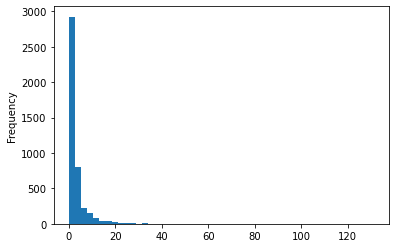

In [20]:
# Create a distribution of frequency to understand the customer frequence level
summary['frequency'].plot(kind='hist', bins=50)
print(summary['frequency'].describe())
print("-------------------------------")
one_time_buyers = round(sum(summary['frequency'] == 0)/float(len(summary))*(100),2)
print("Percentage of customers who purchased an item exactly once, so-called one-time customers:", one_time_buyers ,"%")

Fitting fit a Beta Geometric/Negative Binomial Distribution(BG/NBD) model

In [24]:
# Using the function BetaGeoFitter() 
bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(summary['frequency'], summary['recency'], summary['T'])

<lifetimes.BetaGeoFitter: fitted with 4338 subjects, a: 0.00, alpha: 68.91, b: 6.75, r: 0.83>

In [25]:
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,0.826542,0.026785,0.774044,0.879040
alpha,68.905121,2.611786,63.786020,74.024221
a,0.003437,0.010339,-0.016828,0.023702
b,6.745116,22.414725,-37.187745,50.677978


#### model.conditional_probability_alive(frequency, recency, T) <br>
https://lifetimes.readthedocs.io/en/latest/lifetimes.html?highlight=conditional_probability_alive#lifetimes.BetaGeoFitter.conditional_probability_alive <br>
It computes the probability that a customer with history (frequency, recency, T) is currently alive. <br>




In [38]:
# Compute the customer alive probability
summary['probability_alive'] = bgf.conditional_probability_alive(summary['frequency'], summary['recency'], summary['T'])
summary.head(10)

,CustomerID,frequency,recency,T,monetary_value,probability_alive
0,12346.0,0.0,0.0,325.0,0.000000,1.000000
1,12347.0,6.0,365.0,367.0,599.701667,0.999698
2,12348.0,3.0,283.0,358.0,301.480000,0.999177
3,12349.0,0.0,0.0,18.0,0.000000,1.000000
4,12350.0,0.0,0.0,310.0,0.000000,1.000000
5,12352.0,6.0,260.0,296.0,368.256667,0.999406
6,12353.0,0.0,0.0,204.0,0.000000,1.000000
7,12354.0,0.0,0.0,232.0,0.000000,1.000000
8,12355.0,0.0,0.0,214.0,0.000000,1.000000
9,12356.0,2.0,303.0,325.0,269.905000,0.999478


#### plot_probabilty_alive_matrix(model, max_frequency=None, max_recency=None, title='Probability Customer is Alive, \nby Frequency and Recency of a Customer', xlabel="Customer's Historical Frequency", ylabel="Customer's Recency", **kwargs) <br>
https://lifetimes.readthedocs.io/en/latest/lifetimes.html?highlight=plot_probabilty_alive_matrix#lifetimes.plotting.plot_probability_alive_matrix <br>
Parameters:	<br>
model (lifetimes model) – A fitted lifetimes model. <br>
max_frequency (int, optional) – The maximum frequency to plot. Default is max observed frequency. <br>
max_recency (int, optional) – The maximum recency to plot. This also determines the age of the customer. Default to max observed age. <br>
title (str, optional) – Figure title <br>
xlabel (str, optional) – Figure xlabel <br>
ylabel (str, optional) – Figure ylabel <br>
kwargs – Passed into the matplotlib.imshow command. <br>
<br>
It plots Plot probability alive matrix as heatmap, which is a figure of the probability a customer is alive based on their frequency and recency. <br>

<AxesSubplot:title={'center':'Probability Customer is Alive,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

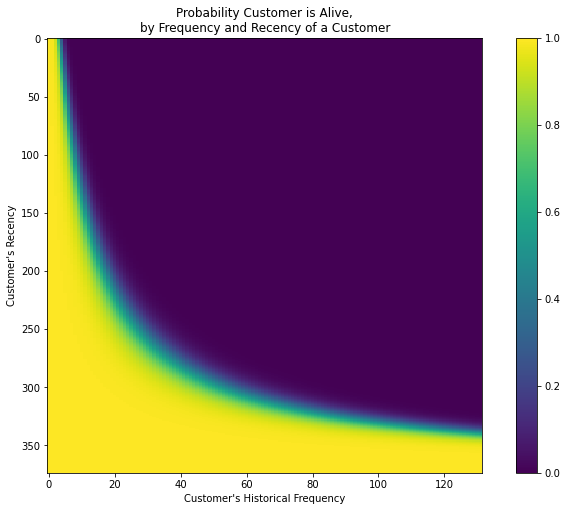

In [40]:
fig = plt.figure(figsize=(12,8))
plot_probability_alive_matrix(bgf)

My interpretation:
If a customer has bought multiple times, meaning with greater than 0 frequency, and the time between first & last transaction is high, meaning high recency, then his/her probability being alive is high, which is showing a color scale on the gradient that is closer to yellow, i.e. 1.0. <br>
Similarly, if a customer has a lower frequency, e.g. closer to 1 times, and the time between first & last transaction is low, meaning low recency, then his/her probability being alive is high, which corresponds to a color scale on the gradient that is closer to yellow, again, i.e. 1.0. <br>


#### model.conditional_expected_number_of_purchases_up_to_time(t, frequency, recency, T) <br> 
https://lifetimes.readthedocs.io/en/latest/lifetimes.html?highlight=plot_probabilty_alive_matrix#lifetimes.BetaGeoFitter.conditional_expected_number_of_purchases_up_to_time <br>
It calculates the expected number of repeat purchases up to time t for a randomly chosen individual from the population, given they have purchase history (frequency, recency, T)

In [41]:
#Predict future transaction for the next 30 days based on historical dataa
t = 30
summary['pred_num_txn'] = round(bgf.conditional_expected_number_of_purchases_up_to_time(t, summary['frequency'], summary['recency'], summary['T']),2)
summary.sort_values(by='pred_num_txn', ascending=False).head(10).reset_index()

,index,CustomerID,frequency,recency,T,monetary_value,probability_alive,pred_num_txn
0,1879,14911.0,131.0,372.0,373.0,1093.661679,0.999966,8.95
1,326,12748.0,112.0,373.0,373.0,301.024821,0.999971,7.66
2,4010,17841.0,111.0,372.0,373.0,364.452162,0.999962,7.59
3,2176,15311.0,89.0,373.0,373.0,677.729438,0.999964,6.10
4,1661,14606.0,88.0,372.0,373.0,135.890114,0.999955,6.03
5,481,12971.0,70.0,369.0,372.0,159.211286,0.999926,4.82
6,562,13089.0,65.0,367.0,369.0,893.714308,0.999934,4.51
7,1602,14527.0,53.0,367.0,369.0,155.016415,0.999925,3.69
8,1069,13798.0,52.0,371.0,372.0,706.650962,0.999933,3.59
9,2990,16422.0,47.0,352.0,369.0,702.472340,0.999567,3.27


The results shown above is the first 10 days of the predicted number of repeat purchases (pred_num_txn).

While the BG/NBD model can only be used to predict the future transactions and churn rate of customers, we still need to model for the monetary value with a Gamma-Gamma model. 

Some of the key assumptions of Gamma-Gamma model are:

1. The monetary value of a customer's given transaction varies randomly around their average transaction value.
2. Average transaction value varies across customers but do not vary over time for any given customer.
3. The distribution of average transaction values across customers is independent of the transaction process.

We can validate the 3rd assumption by looking into the correlation between frequency and monetary value. For the interest of time and the objective of this blog, I'm going to skip this step.

#### GammaGammaFitter(penalizer_coef=0.0) 
It's used to estimate the average monetary value of customer transactions

In [49]:
# Checking the relationship between frequency and monetary_value
return_customers_summary = summary[summary['frequency']>0]
print(return_customers_summary.shape)
return_customers_summary.head()

(2790, 7)


,CustomerID,frequency,recency,T,monetary_value,probability_alive,pred_num_txn
1,12347.0,6.0,365.0,367.0,599.701667,0.999698,0.47
2,12348.0,3.0,283.0,358.0,301.480000,0.999177,0.27
5,12352.0,6.0,260.0,296.0,368.256667,0.999406,0.56
9,12356.0,2.0,303.0,325.0,269.905000,0.999478,0.22
11,12358.0,1.0,149.0,150.0,683.200000,0.999486,0.25


In [50]:
# Modeling the monetary value using Gamma-Gamma Model
ggf = lifetimes.GammaGammaFitter(penalizer_coef=0.001)
ggf.fit(return_customers_summary['frequency'],
       return_customers_summary['monetary_value'])

<lifetimes.GammaGammaFitter: fitted with 2790 subjects, p: 11.13, q: 0.84, v: 11.29>

In [51]:
# Summary of the fitted parameters
ggf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
p,11.125568,0.269274,10.597792,11.653344
q,0.838782,0.019731,0.800110,0.877455
v,11.292978,0.281539,10.741162,11.844795


#### model.conditional_expected_average_profit(frequency=None, monetary_value=None)
https://lifetimes.readthedocs.io/en/latest/lifetimes.html?highlight=conditional_expected_average_profit#lifetimes.GammaGammaFitter.conditional_expected_average_profit
This method computes the conditional expectation of the average profit per transaction for a group of one or more customers.

In [52]:
summary = summary[summary['monetary_value'] >0]
summary['exp_avg_sales'] = ggf.conditional_expected_average_profit(summary['frequency'],
                                       summary['monetary_value'])
summary.head()

,CustomerID,frequency,recency,T,monetary_value,probability_alive,pred_num_txn,exp_avg_sales
1,12347.0,6.0,365.0,367.0,599.701667,0.999698,0.47,603.040247
2,12348.0,3.0,283.0,358.0,301.480000,0.999177,0.27,306.725889
5,12352.0,6.0,260.0,296.0,368.256667,0.999406,0.56,371.034926
9,12356.0,2.0,303.0,325.0,269.905000,0.999478,0.22,277.562534
11,12358.0,1.0,149.0,150.0,683.200000,0.999486,0.25,704.704679


The method above only gives us the expected average sales. We now then need to multiple that with expected profit margin to get the actual average sales, which is the CLV.

#### model.customer_lifetime_value(transaction_prediction_model, frequency, recency, T, monetary_value, time=12, discount_rate=0.01, freq='D') <br>
https://lifetimes.readthedocs.io/en/latest/lifetimes.html?highlight=customer_lifetime_value#lifetimes.GammaGammaFitter.customer_lifetime_value <br>
<br>
##### Parameters:	<br>
transaction_prediction_model (model) – the model to predict future transactions, literature uses pareto/ndb models but we can also use a different model like beta-geo models <br>
frequency (array_like) – the frequency vector of customers’ purchases (denoted x in literature). <br>
recency (the recency vector of customers' purchases) – (denoted t_x in literature). <br>
T (array_like) – customers’ age (time units since first purchase) <br>
monetary_value (array_like) – the monetary value vector of customer’s purchases (denoted m in literature). <br>
time (float, optional) – the lifetime expected for the user in months. Default: 12 <br>
discount_rate (float, optional) – the monthly adjusted discount rate. Default: 0.01 <br>
freq (string, optional) – {“D”, “H”, “M”, “W”} for day, hour, month, week. This represents what unit of time your T is measure in. <br>

In [56]:
# Checking the expected average value and the actual average value in the data to verify that the values are comparable
print(f"Expected Average Sales: {summary['exp_avg_sales'].mean()}")
print(f"Actual Average Sales: {summary['monetary_value'].mean()}")

Expected Average Sales: 486.90902215126755
Actual Average Sales: 477.3803385139513


discount_rate: This parameter is based on the concept of DCF (discounted cash flow), where you will discount the future monetary value by a discount rate to get the present value of that cash flow. In the documentation, it is given that for monthly it is 0.01 (annually ~12.7%).

In [66]:
# Predicting Customer Lifetime Value for the next 12 months
summary['predicted_clv'] =      ggf.customer_lifetime_value(bgf,
                                                               summary['frequency'],
                                                               summary['recency'],
                                                               summary['T'],
                                                               summary['monetary_value'],
                                                               # freq='D',   # frequency in which the data is present(T)      
                                                               ) 
summary.head()

,CustomerID,frequency,recency,T,monetary_value,probability_alive,pred_num_txn,exp_avg_sales,predicted_clv,manual_predicted_clv,CLV
1,12347.0,6.0,365.0,367.0,599.701667,0.999698,0.47,603.040247,3185.475742,3401.146996,258.023535
2,12348.0,3.0,283.0,358.0,301.480000,0.999177,0.27,306.725889,926.978990,993.791880,75.085298
5,12352.0,6.0,260.0,296.0,368.256667,0.999406,0.56,371.034926,2340.318003,2493.354700,189.565758
9,12356.0,2.0,303.0,325.0,269.905000,0.999478,0.22,277.562534,671.754664,732.765090,54.412128
11,12358.0,1.0,149.0,150.0,683.200000,0.999486,0.25,704.704679,1982.735059,2114.114036,160.601540


In [67]:
summary['manual_predicted_clv'] = summary['pred_num_txn'] * summary['exp_avg_sales'] * 12
summary.head()

,CustomerID,frequency,recency,T,monetary_value,probability_alive,pred_num_txn,exp_avg_sales,predicted_clv,manual_predicted_clv,CLV
1,12347.0,6.0,365.0,367.0,599.701667,0.999698,0.47,603.040247,3185.475742,3401.146996,258.023535
2,12348.0,3.0,283.0,358.0,301.480000,0.999177,0.27,306.725889,926.978990,993.791880,75.085298
5,12352.0,6.0,260.0,296.0,368.256667,0.999406,0.56,371.034926,2340.318003,2493.354700,189.565758
9,12356.0,2.0,303.0,325.0,269.905000,0.999478,0.22,277.562534,671.754664,732.765090,54.412128
11,12358.0,1.0,149.0,150.0,683.200000,0.999486,0.25,704.704679,1982.735059,2114.114036,160.601540


Commentaries: Both the CLVs  are very close to each other and look reasonable for the next 12 months.

In [68]:
# CLV in terms of profit (profit margin is 8.1%)
profit_margin = 0.081
summary['CLV'] = summary['predicted_clv'] * profit_margin
summary.head()

,CustomerID,frequency,recency,T,monetary_value,probability_alive,pred_num_txn,exp_avg_sales,predicted_clv,manual_predicted_clv,CLV
1,12347.0,6.0,365.0,367.0,599.701667,0.999698,0.47,603.040247,3185.475742,3401.146996,258.023535
2,12348.0,3.0,283.0,358.0,301.480000,0.999177,0.27,306.725889,926.978990,993.791880,75.085298
5,12352.0,6.0,260.0,296.0,368.256667,0.999406,0.56,371.034926,2340.318003,2493.354700,189.565758
9,12356.0,2.0,303.0,325.0,269.905000,0.999478,0.22,277.562534,671.754664,732.765090,54.412128
11,12358.0,1.0,149.0,150.0,683.200000,0.999486,0.25,704.704679,1982.735059,2114.114036,160.601540


In [69]:
summary['CLV'].describe()

count     2790.000000
mean       226.538985
std        907.639599
min          2.507232
25%         52.001373
50%        104.307267
75%        201.811261
max      31142.494438
Name: CLV, dtype: float64

In [79]:
print(f"So the predicted Customer Lifetime Value (pCLV) for the next 12-month is {round(summary['CLV'].describe()[1],2)}!")

So the predicted Customer Lifetime Value (pCLV) for the next 12-month is 226.54!


#### Use case: <br>
We can now use some custom segmentation based on campaigns, business rules to recalculate the CLV then we can deploy this calculation in an automated fashion. Or, we can also leverage RFM segmentation to couple with these CLV calculations to deploy a full suite of tactics around this.

# References: 
1. https://www.analyticsvidhya.com/blog/2020/10/a-definitive-guide-for-predicting-customer-lifetime-value-clv/
2. https://lifetimes.readthedocs.io/en/latest/lifetimes.html?highlight=customer_lifetime_value#